# 3. Ensemble Learning 

## Bagging

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from icecream import ic
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import copy

# Import the necessary models

In [67]:
from DecisionTrees import DecisionTree
from MultiLayerPerceptron import MLP, CrossEntropyLoss
from MLR import MLR # Multinomial Logistic Regression

In [68]:
class BaggingForClassifier:
    def __init__(self, base_estimator, n_estimators, fraction, bootstrap, voting_mechanism):
        
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.fraction = fraction
        self.bootstrap = bootstrap
        self.voting_mechanism = voting_mechanism
        if self.voting_mechanism == 'hard':
            self.predict = self.predict_hard
        elif self.voting_mechanism == 'soft':
            self.predict = self.predict_soft
        self.models = [copy.deepcopy(self.base_estimator) for i in range(n_estimators)]
        
        # print(self.models)
        
    def train(self, X, y, X_val=None, y_val=None): # X_val, y_val is used to calculate the confidence
        for i in range(self.n_estimators):
            # bootstrap is given to the np.random.choice
            idx = np.random.choice(X.shape[0], size=int(self.fraction * X.shape[0]), replace=self.bootstrap)
            X_sample = X[idx]
            y_sample = y[idx]
            self.models[i].fit(X_sample, y_sample, epochs = 1000)    
        if X_val is not None and y_val is not None:
            self.predict(X_val, y_val)
        
    def predict_hard(self, X, y):
        predictions = np.zeros((X.shape[0], len(self.models)))
        
        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict(X).argmax(axis=1)
            
        final_predictions = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=predictions)
        return final_predictions
    
    def predict_soft(self, X, y):
        predictions = np.zeros((X.shape[0], len(self.models), y.shape[1]))  # Adjust num_classes to the number of classes in your problem
        
        for i, model in enumerate(self.models):
            predictions[:, i, :] = model.predict(X)
            
        avg_predictions = np.mean(predictions, axis=1)
        final_predictions = avg_predictions.argmax(axis=1)
        # final_predictions = (avg_predictions > 0.5).astype(int)
        return final_predictions


In [69]:
PATH_TO_WINE_QT = "./Dataset/WineQT.csv"

df = pd.read_csv(PATH_TO_WINE_QT)

X = df.drop(columns=["quality", "Id"])
y = df.quality

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [70]:
y.value_counts()

quality
5    483
6    462
7    143
4     33
8     16
3      6
Name: count, dtype: int64

In [71]:
y.describe()

count    1143.000000
mean        5.657043
std         0.805824
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

In [72]:
y = pd.get_dummies(y)
y.replace(False, 0, inplace=True)
y.replace(True, 1, inplace=True)
y = y.values
y

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0]])

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% training and 20% test
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5) # 50% test and 50% validation

In [74]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]

In [75]:
bfc = BaggingForClassifier(DecisionTree(), 2, 0.75, True, 'soft')
print(bfc.models)

[<DecisionTrees.DecisionTree object at 0x7f61d60c3bd0>, <DecisionTrees.DecisionTree object at 0x7f61d6116390>]


For ease, assume the best hyper-parameters from sub-task 1 and train
ensemble models across all combinations of parameters specified above
and report the best performing models.

In [76]:
best_model = None
best_acc = 0

list_for_comparison = []
for model in tqdm([DecisionTree(),
              MLP(
    input_size=input_size,
        hidden_layer_sizes=[32, 32],
        output_size=output_size,
        activation_function=["relu", "relu"],
        output_activation_function="softmax",
        optimizer="bgd",
        loss=CrossEntropyLoss(),
        learning_rate=0.001),
        MLR()]):
    for n_estimator in range(1, 4):
        for fraction in [0.15, 0.25, 0.5, 0.75, 1.0]:
            for bootstrap in [True, False]:
                for voting_mechanism in ["hard", "soft"]:
                    bfc = BaggingForClassifier(base_estimator=model,
                                               n_estimators=n_estimator, fraction=fraction, bootstrap=bootstrap, voting_mechanism=voting_mechanism)
                    # ic(bfc.models, n_estimator, fraction,2 bootstrap, voting_mechanism)
                    bfc.train(X_train, y_train)
                    pred = bfc.predict(X_val, y_val)
                    acc = accuracy_score(pred, np.argmax(y_val, axis=1))
                    
                    list_for_comparison.append([model.__class__.__name__, n_estimator, fraction, bootstrap, voting_mechanism, acc])
                    if acc > best_acc:
                        best_acc = accuracy_score(pred, np.argmax(y_val, axis=1))
                        best_model = bfc
                        # print(f"n_estimator: {n_estimator}, fraction: {fraction}, bootstrap: {bootstrap}, voting_mechanism: {voting_mechanism}")
                        # print(best_acc)
print(f"model: {best_model.models}, n_estimator: {best_model.n_estimators}, fraction: {best_model.fraction}, bootstrap: {best_model.bootstrap}, voting_mechanism: {best_model.voting_mechanism}")
print(best_acc)

  0%|          | 0/3 [00:00<?, ?it/s]

model: [<MLR.MLR object at 0x7f61d6110650>], n_estimator: 1, fraction: 0.15, bootstrap: True, voting_mechanism: soft
0.6347826086956522


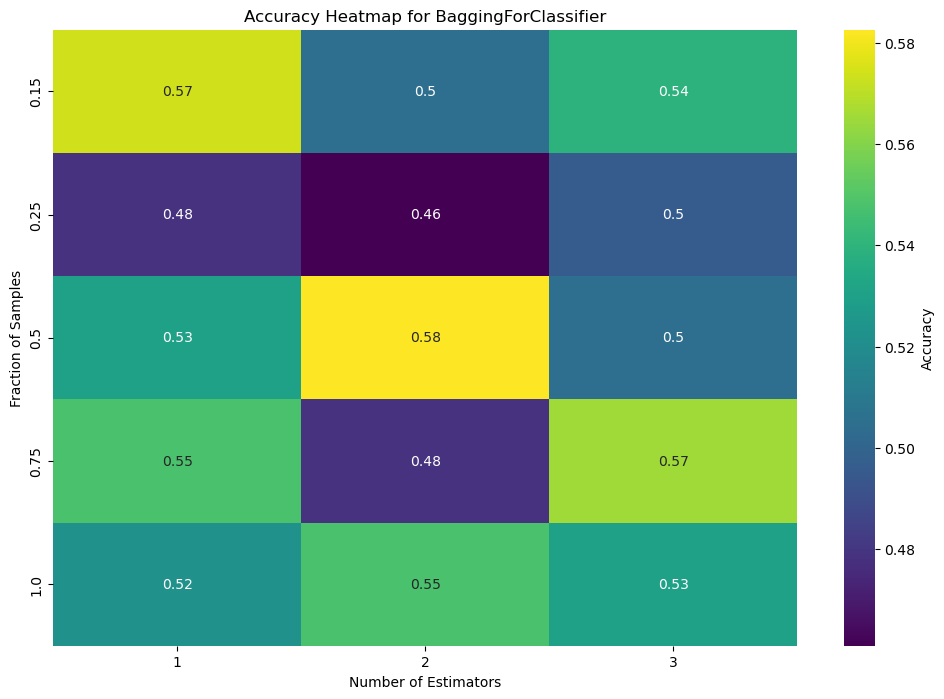

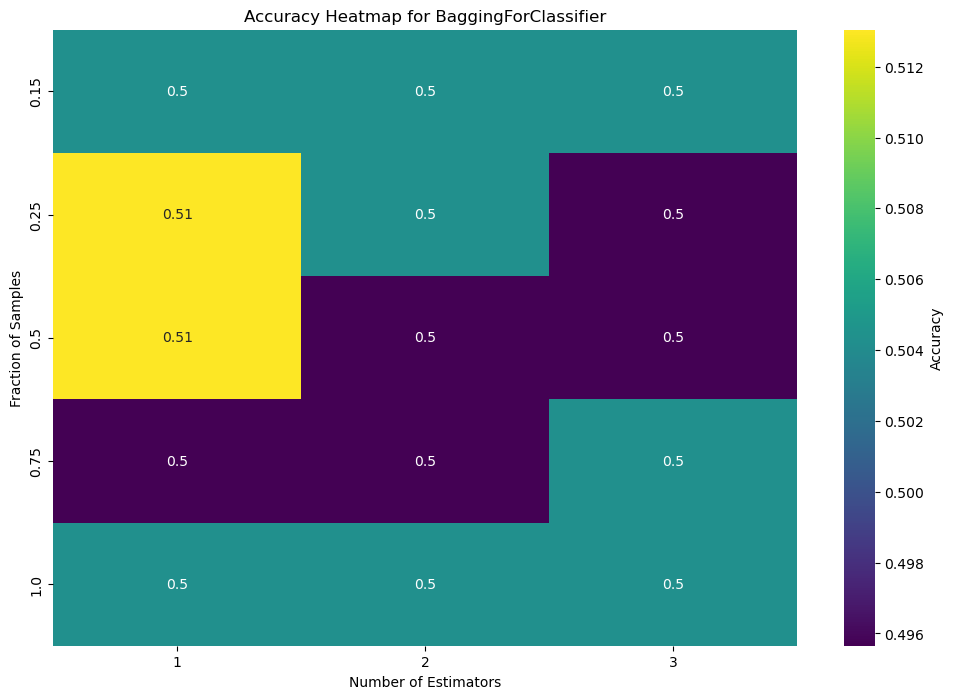

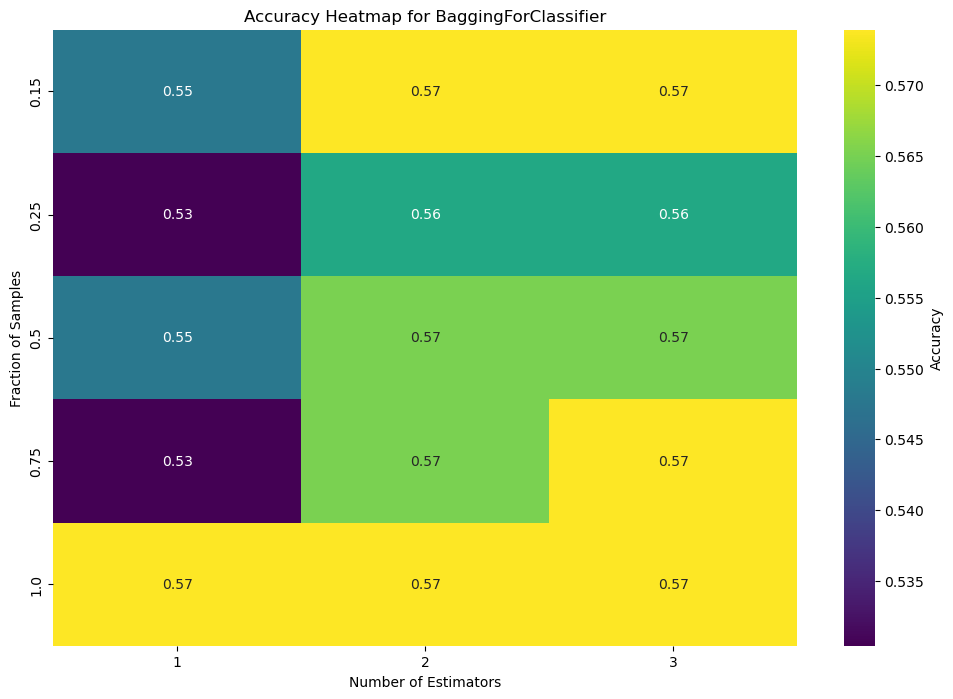

In [77]:
best_model = None
best_acc = 0
for model in [DecisionTree(),
              MLP(
    input_size=input_size,
        hidden_layer_sizes=[32, 32],
        output_size=output_size,
        activation_function=["relu", "relu"],
        output_activation_function="softmax",
        optimizer="bgd",
        loss=CrossEntropyLoss(),
        learning_rate=0.001),
        MLR()]:
    list_for_plotting = []
    for n_estimator in range(1, 4):
        for fraction in [0.15, 0.25, 0.5, 0.75, 1.0]:
            for bootstrap in [False]:
                for voting_mechanism in ["hard"]:
                    bfc = BaggingForClassifier(base_estimator=model,
                                               n_estimators=n_estimator, fraction=fraction, bootstrap=bootstrap, voting_mechanism=voting_mechanism)
                    # ic(bfc.models, n_estimator, fraction,2 bootstrap, voting_mechanism)
                    bfc.train(X_train, y_train)
                    pred = bfc.predict(X_val, y_val)
# Plot a heatmap for the accuracies obtained by each class of base estimator
# models across Fraction of Samples and Number of Estimators (Keep other
# parameters constant and to your choice)
                    list_for_plotting.append([n_estimator, fraction, accuracy_score(y_true=y_val.argmax(axis=1), y_pred=pred)])
    df_plot = pd.DataFrame(list_for_plotting, columns=["n_estimator", "fraction", "accuracy"])
    heatmap = df_plot.pivot(columns = "n_estimator", index = "fraction", values = "accuracy")
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap, annot=True, cmap="viridis", cbar_kws={'label': 'Accuracy'})#, fmt=".3f")
    print(model)
    plt.title('Accuracy Heatmap for BaggingForClassifier')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Fraction of Samples')
    plt.show()
                    

In [78]:
ind_comp = []
for individual_model in [DecisionTree(),\
    MLP(input_size=input_size, hidden_layer_sizes=[32, 32],\
        output_size=output_size, activation_function=["relu", "relu"],\
            output_activation_function="softmax", optimizer="bgd",\
                loss=CrossEntropyLoss(), learning_rate=0.001)
    , MLR()]:
    
    individual_model.fit(X_train, y_train, epochs=1000)
    y_pred = individual_model.predict(X_val)
    acc = accuracy_score(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_val, axis=1))
    # print(f"model: {individual_mode.__class__.__name__}, acc: {acc}")
    ind_comp.append([individual_model.__class__.__name__, acc])
    # print(ind_comp)

ind_comp_dict = {}
for i in ind_comp:
    ind_comp_dict[i[0]] = i[1]
ind_comp = pd.DataFrame(ind_comp, columns=["model", "accuracy"])

In [79]:
ind_comp

,model,accuracy
0,DecisionTree,0.521739
1,MLP,0.530435
2,MLR,0.573913


In [80]:
# Compare the performance of each model in List 1 models with the best-
# performing ensemble model of the same class with a single side-by-side
# histogram
# Everything is in list_for_comparison

df_comparison = pd.DataFrame(list_for_comparison, columns=["model", "n_estimator", "fraction", "bootstrap", "voting_mechanism", "accuracy"])

# get the highest accuracy for each model
df_comparison.groupby("model").max("accuracy")

df = df_comparison.groupby("model").max("accuracy")

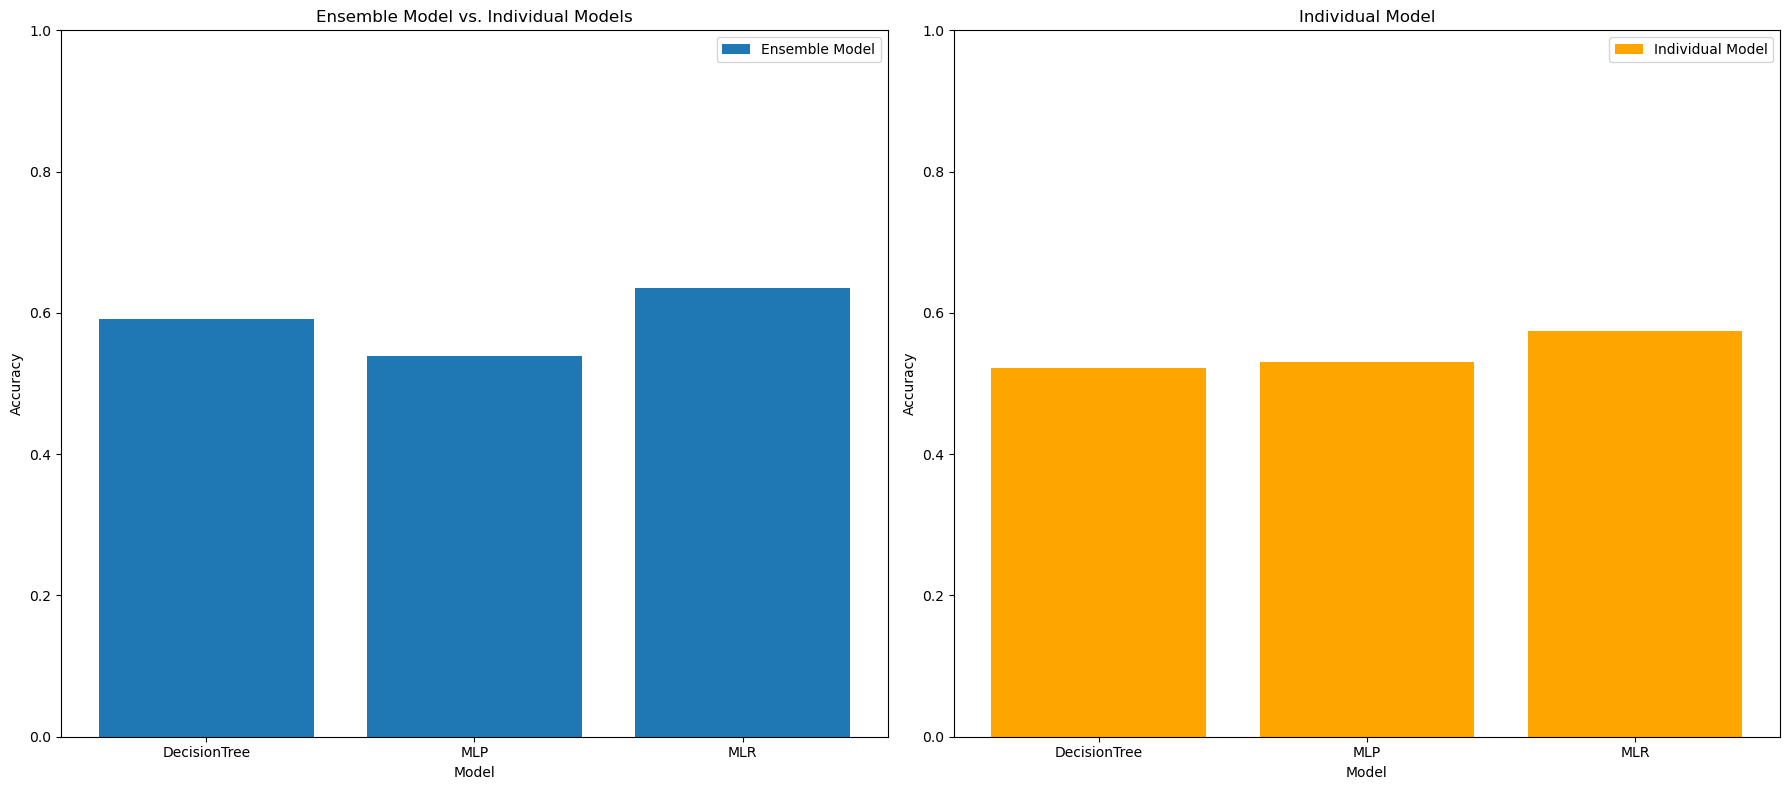

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plotting the ensemble model and individual models on the first subplot (ax1)
ax1.bar(df.index, df.accuracy, label="Ensemble Model")
ax1.set_xlabel("Model")
ax1.set_ylim(0.0, 1.0)
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.set_title("Ensemble Model vs. Individual Models")

# Plotting the individual models on the second subplot (ax2)
ax2.bar(ind_comp.model, ind_comp.accuracy, label="Individual Model", color = "orange")
ax2.set_xlabel("Model")
ax2.set_ylim(0.0, 1.0)
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.set_title("Individual Model")

# Adjust layout for better visibility
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
%reset

# For Regression

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from icecream import ic
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import copy
from sklearn.metrics import mean_squared_error as mse

In [174]:
from DecisionTreeRegression import DecisionTreeRegressorWrapper
from MultiLayerRegression import MultiLayerRegression
from MultiLayerRegression import MSELoss
from LinearRegression import LinearRegression

In [175]:
class BaggingForRegressor:
    def __init__(self, base_estimator, n_estimators, fraction, bootstrap, voting_mechanism):        
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.fraction = fraction
        self.bootstrap = bootstrap
        self.voting_mechanism = voting_mechanism
        
        if self.voting_mechanism == 'hard':
            self.predict = self.predict_hard
        elif self.voting_mechanism == 'soft':
            self.predict = self.predict_soft
            
            
            
            
        self.models = [copy.deepcopy(self.base_estimator) for _ in range(n_estimators)]

    def train(self, X, y, X_val=None, y_val=None):  # X_val, y_val is used to calculate the confidence
        for i in range(self.n_estimators):
            # bootstrap is given to the np.random.choice
            idx = np.random.choice(X.shape[0], size=int(self.fraction * X.shape[0]), replace=self.bootstrap)
            X_sample = X[idx]
            y_sample = y[idx]
            
            # print(X_sample.shape)
            # print(y_sample.shape)
            # print(self.models[i])
            if self.models[0].__class__.__name__ == "LinearRegression":
                self.models[i].fit(X_sample, y_sample.squeeze(), epochs=1000)
            else:
                self.models[i].fit(X_sample, y_sample, epochs=1000)

            # self.predict(X_val, y_val)

    def predict_hard(self, X, y):
        predictions = np.zeros((X.shape[0], len(self.models)))

        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict(X).flatten()
            # predictions = model.predict(X)

        final_predictions = np.mean(predictions, axis=1)
        # print(final_predictions)
        return final_predictions

    def predict_soft(self, X, y):
        predictions = np.zeros((X.shape[0], len(self.models)))

        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict(X).flatten()
            
        # calculate the mse for each prediction
        mse_predictions = np.zeros((len(self.models)))
        for i, model in enumerate(self.models):
            mse_predictions[i] = mse(y.flatten(), predictions[:, i])
        confidences = 1 / (mse_predictions + 1e-10)
        # print(mse_predictions)
        confidences = confidences / np.sum(confidences)
        # print(mse_predictions)
        
        weighted_predictions = np.zeros((X.shape[0]))
        for i, model in enumerate(self.models):
            weighted_predictions += predictions[:, i] * confidences[i]
        # avg_predictions = np.mean(predictions, axis=1)
        final_predictions = weighted_predictions
        return final_predictions


In [176]:
PATH_TO_BOSTON_HOUSING_DATASET = "./Dataset/HousingData.csv"

In [177]:
df = pd.read_csv(PATH_TO_BOSTON_HOUSING_DATASET)

In [178]:
df.isnull().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [179]:
# fill the nan values 
# except for the CHAS column it is a categorical variable
df["CHAS"] = df.CHAS.fillna(df.CHAS.mode()[0])
df = df.fillna(df.mean())

In [180]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [181]:
# standardize the data except the target column 'MEDV' and "CHAS"
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(['MEDV', 'CHAS'], axis=1))
df_scaled = pd.DataFrame(df_scaled, columns=df.drop(["CHAS", "MEDV"], axis=1).columns)
df_scaled["CHAS"] = df["CHAS"]

In [182]:
X = df_scaled.values
y = df["MEDV"].values

input_size = X.shape[1]

# because it's regression
output_size = 1

In [183]:
# split into train test and validation test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

In [184]:
y_train.shape, y_test.shape, y_val.shape

((404,), (51,), (51,))

In [185]:
y_test = y_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

In [186]:
y_train.shape, y_test.shape, y_val.shape

((404, 1), (51, 1), (51, 1))

In [187]:
# bfr = BaggingForRegressor(base_estimator=LinearRegression(),\
#     n_estimators=5, fraction=0.75, bootstrap=True,\
#     voting_mechanism="soft")

# bfr.train(X_train, y_train, X_val, y_val)
# bfr.predict(X_val, y_val)

In [188]:
# input_size = X_train.shape[1]
# output_size = 1

# bfr = BaggingForRegressor(base_estimator=MultiLayerRegression(\
#     input_size=input_size,\
#         hidden_layer_sizes=[32, 32],\
#             output_size=output_size, activation_function=["relu", "relu"],\
#                 output_activation_function="identity",\
#                     optimizer="bgd",\
#                         loss = MSELoss(),\
#                             learning_rate=0.001),\
#     n_estimators=4, fraction=0.75, bootstrap=True,\
#     voting_mechanism="soft")

# bfr.train(X_train, y_train)

# bfr.predict(X_val, y_val)

In [189]:
# bfr = BaggingForRegressor(DecisionTreeRegressorWrapper(),\
#     n_estimators=5, fraction=0.75, bootstrap=True,\
#     voting_mechanism="soft")
# bfr.train(X_train, y_train)
# bfr.predict(X_val, y_val)

In [190]:
input_size = X_train.shape[1]
output_size = 1

In [191]:
# find the best performing model
best_model = None
best_mse = 1000000000

list_for_comparison = []

for model in [LinearRegression(), MultiLayerRegression(\
    input_size=input_size,\
        hidden_layer_sizes=[32, 32],\
            output_size=output_size, activation_function=["relu", "relu"],\
                output_activation_function="identity",\
                    optimizer="bgd",\
                        loss = MSELoss(),\
                            learning_rate=0.001), DecisionTreeRegressorWrapper()]:
    for n_estimator in range(1, 4):
        for fraction in [0.15, 0.25, 0.5, 0.75, 1.0]:
            for bootstrap in [True, False]:
                for voting_mechanism in ["hard", "soft"]:
                    bfr = BaggingForRegressor(base_estimator=model,\
                        n_estimators=n_estimator, fraction=fraction, bootstrap=bootstrap,\
                            voting_mechanism=voting_mechanism)
                    # ic(bfc.models, n_estimator, fraction,2 bootstrap, voting_mechanism)
                    bfr.train(X_train, y_train)
                    pred = bfr.predict(X_test, y_test)
                    mean_squared_error = mse(y_true=y_test, y_pred=pred)
                    list_for_comparison.append([model.__class__.__name__, n_estimator, fraction, bootstrap, voting_mechanism, mean_squared_error])
                    if mean_squared_error < best_mse:
                        best_mse = mean_squared_error
                        best_model = bfr
print(f"model: {best_model.models}, n_estimator: {best_model.n_estimators}, fraction: {best_model.fraction}, bootstrap: {best_model.bootstrap}, voting_mechanism: {best_model.voting_mechanism}")
print(best_mse)
                    
                    

model: [<MultiLayerRegression.MultiLayerRegression object at 0x7ff3bd63f190>], n_estimator: 1, fraction: 1.0, bootstrap: False, voting_mechanism: soft
5.454128292898479


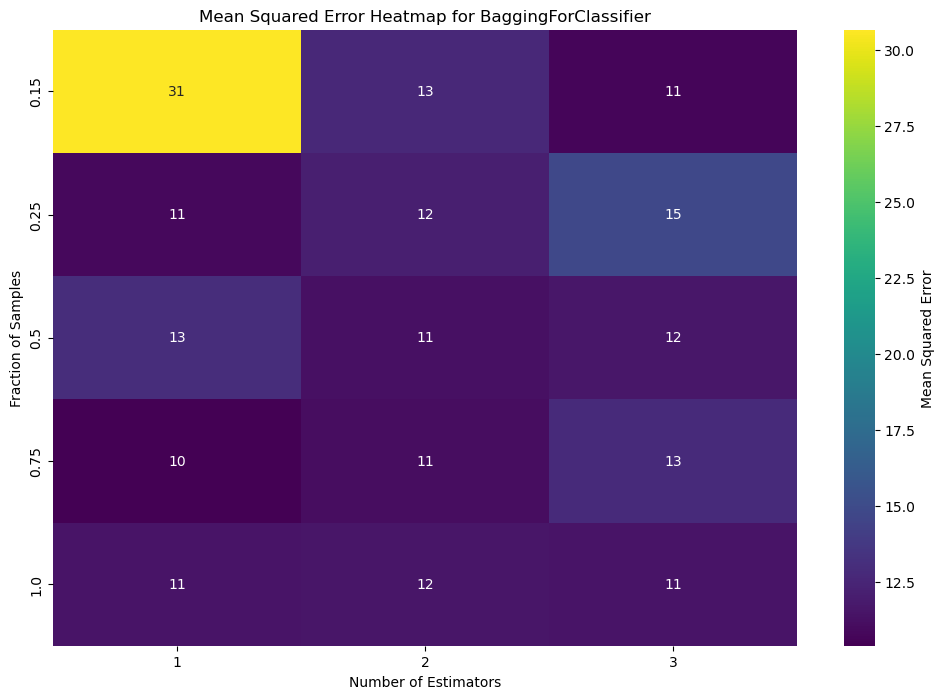

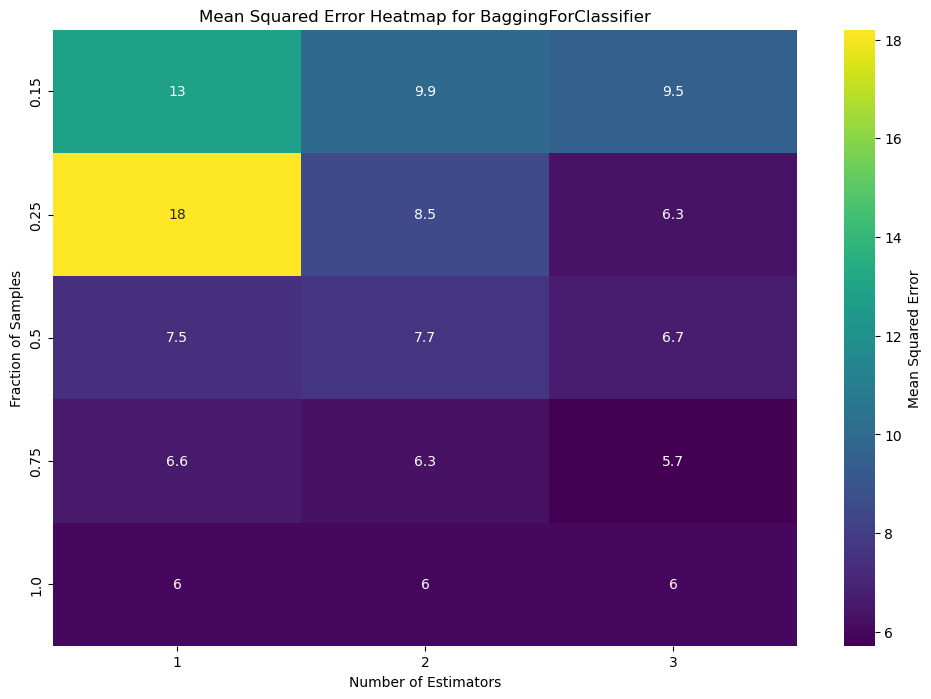

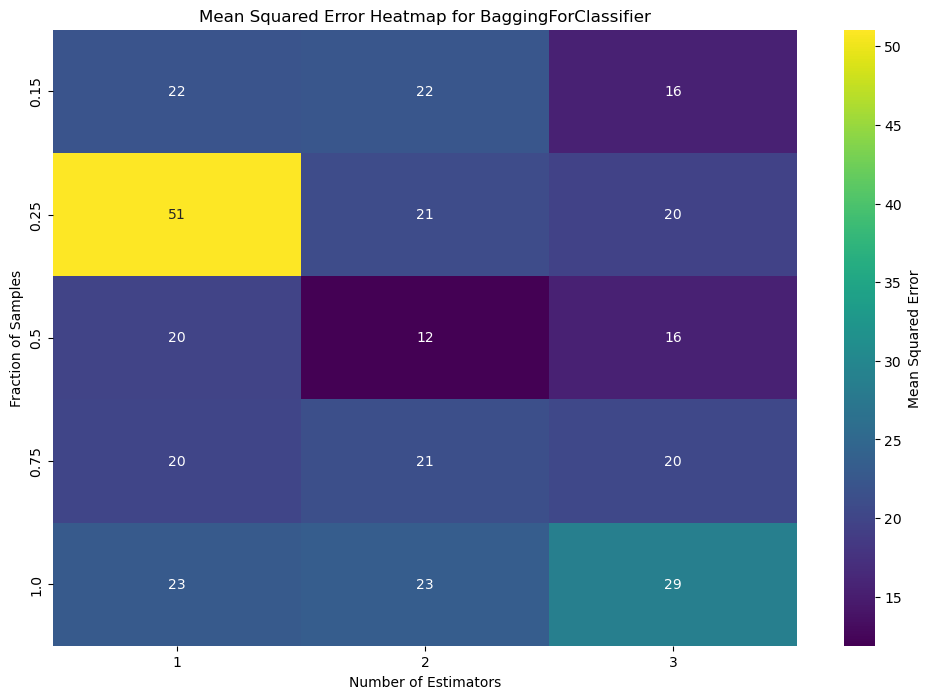

In [192]:
# find the best performing model
best_model = None
best_mse = 1000000000

for model in [LinearRegression(), MultiLayerRegression(\
    input_size=input_size,\
        hidden_layer_sizes=[32, 32],\
            output_size=output_size, activation_function=["relu", "relu"],\
                output_activation_function="identity",\
                    optimizer="bgd",\
                        loss = MSELoss(),\
                            learning_rate=0.001), DecisionTreeRegressorWrapper()]:
    list_for_plotting = []
    for n_estimator in range(1, 4):
        for fraction in [0.15, 0.25, 0.5, 0.75, 1.0]:
            for bootstrap in [False]:
                for voting_mechanism in ["hard"]:
                    bfr = BaggingForRegressor(base_estimator=model,\
                        n_estimators=n_estimator, fraction=fraction, bootstrap=bootstrap,\
                            voting_mechanism=voting_mechanism)
                    # ic(bfc.models, n_estimator, fraction,2 bootstrap, voting_mechanism)
                    bfr.train(X_train, y_train)
                    pred = bfr.predict(X_test, y_test)
                    list_for_plotting.append([n_estimator, fraction, mse(y_true=y_test, y_pred=pred)])
    df_plot = pd.DataFrame(list_for_plotting, columns=["n_estimator", "fraction", "mse"])
    # print(df_plot)
    heatmap = df_plot.pivot(columns = "n_estimator", index = "fraction", values = "mse")
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap, annot=True, cmap="viridis", cbar_kws={'label': 'Mean Squared Error'})#, fmt=".3f")
    print(model)
    plt.title('Mean Squared Error Heatmap for BaggingForClassifier')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Fraction of Samples')
    plt.show()               
                    

In [193]:
ind_comp = []
for individual_model in [LinearRegression(), MultiLayerRegression(\
    input_size=input_size,\
        hidden_layer_sizes=[32, 32],\
            output_size=output_size, activation_function=["relu", "relu"],\
                output_activation_function="identity",\
                    optimizer="bgd",\
                        loss = MSELoss(),\
                            learning_rate=0.001), DecisionTreeRegressorWrapper()]:
    
    individual_model.fit(X_train, y_train, epochs=1000)
    y_pred = individual_model.predict(X_val).flatten()
    mean_squared_error = mse(y_pred=y_pred, y_true=y_val)
    # print(f"model: {individual_mode.__class__.__name__}, acc: {acc}")
    ind_comp.append([individual_model.__class__.__name__, mean_squared_error])
    # print(ind_comp)

ind_comp_dict = {}
for i in ind_comp:
    ind_comp_dict[i[0]] = i[1]
ind_comp = pd.DataFrame(ind_comp, columns=["model", "mse"])

In [194]:
# Compare the performance of each model in List 1 models with the best-
# performing ensemble model of the same class with a single side-by-side
# histogram
# Everything is in list_for_comparison

df_comparison = pd.DataFrame(list_for_comparison, columns=["model", "n_estimator", "fraction", "bootstrap", "voting_mechanism", "mse"])

df_comparison.groupby("model").min("mse")

df = df_comparison.groupby("model").min("mse")

In [195]:
df_comparison.groupby("model").max("mse")

,n_estimator,fraction,bootstrap,mse
model,,,,
DecisionTreeRegressorWrapper,3,1.0,True,57.664118
LinearRegression,3,1.0,True,24.503529
MultiLayerRegression,3,1.0,True,17.023018


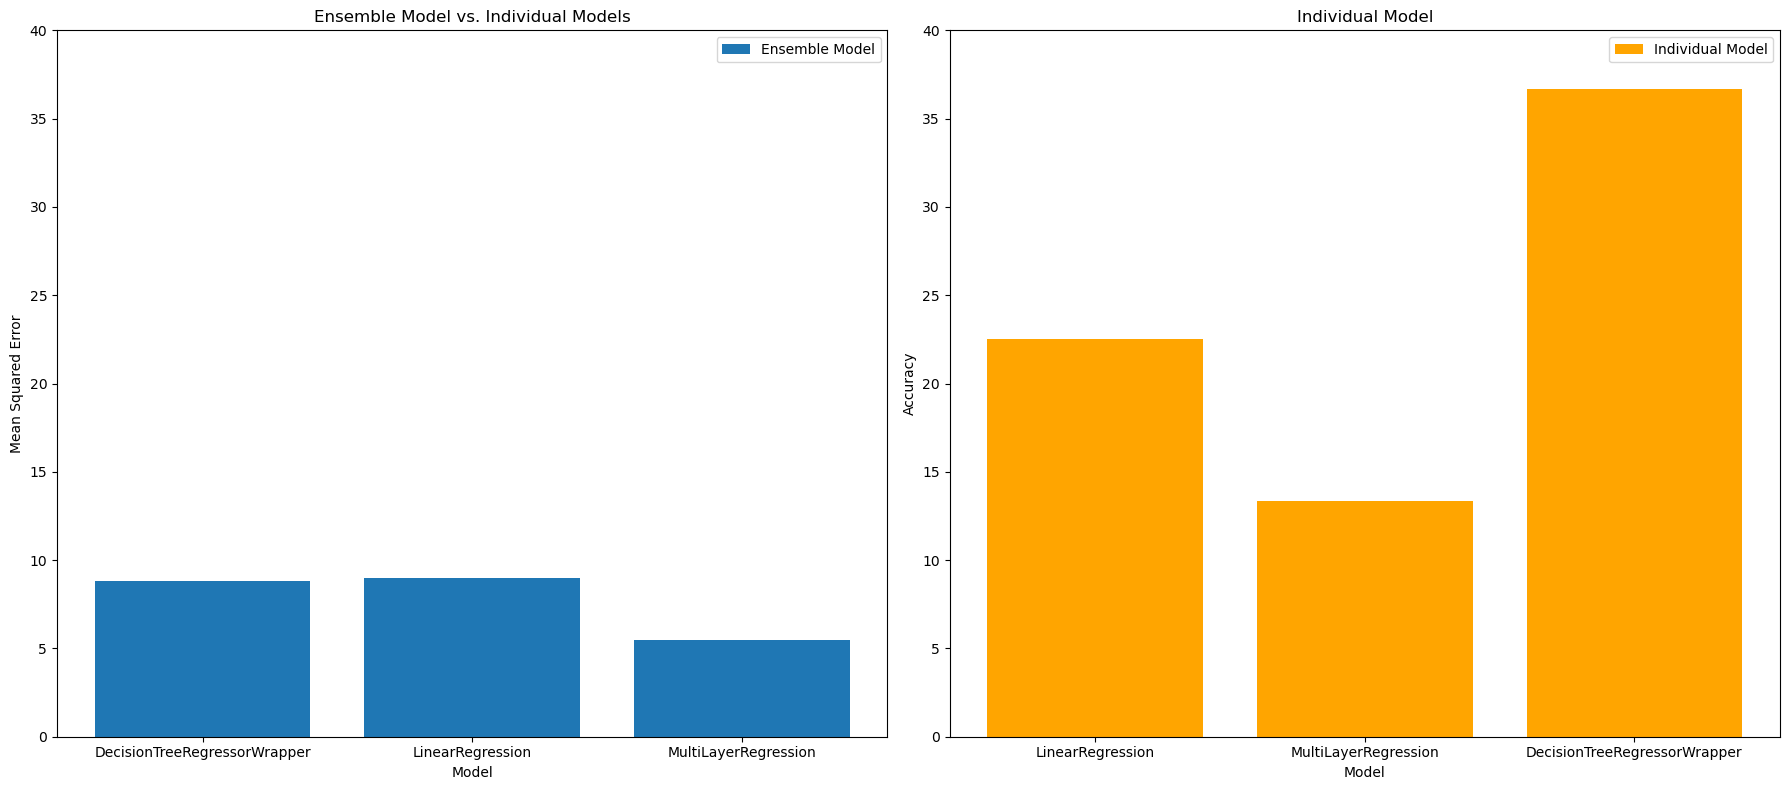

In [197]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plotting the ensemble model and individual models on the first subplot (ax1)
ax1.bar(df.index, df.mse, label="Ensemble Model")
ax1.set_xlabel("Model")
ax1.set_ylim(0.0, 40.0)
ax1.set_ylabel("Mean Squared Error")
ax1.legend()
ax1.set_title("Ensemble Model vs. Individual Models")

# Plotting the individual models on the second subplot (ax2)
ax2.bar(ind_comp.model, ind_comp.mse, label="Individual Model", color = "orange")
ax2.set_xlabel("Model")
ax2.set_ylim(0.0, 40.0)
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.set_title("Individual Model")

# Adjust layout for better visibility
plt.tight_layout()

# Show the plots
plt.show()